In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

## 上一个情感评论的是一次处理为大向量，然后一次性输入网络处理，称为前馈网络
## 但是我们在读句子时，会一个字一个字的读，还会记住之前的内容，RNN就类似这种方式，它处理序列的方式是，遍历所有序列元素，并保存一个状态（state），其中包含与已查看内容相关的信息
## RNN具有内部环，也可以理解为反馈

In [ ]:
# RNN伪代码
# 初始时间的状态没有前一个时间步的状态，所以初始时间的状态是0
state_t = 0
for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t

## 使用Numpy实现RNN

In [2]:
import numpy as np

timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
# 初始状态均0
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

## keras实现RNN

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

2022-04-25 21:11:09.176736: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-04-25 21:11:10.608990: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-04-25 21:11:10.732494: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: NVIDIA TITAN Xp computeCapability: 6.1
coreClock: 1.582GHz coreCount: 30 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 510.07GiB/s
2022-04-25 21:11:10.732565: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-04-25 21:11:10.736670: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-04-25 21:11:10.740158: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [3]:
# 也可以让rnn循环堆叠，此时除了最后一层的输出，其他RNN层都需要返回完整的数据
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


## 将上述模型应用于IMDB电影评论

## 预处理数据

In [4]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000
# 最长度为500的句子
maxlen = 500
batch_size = 32
print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(
    num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')
print('Pad sequences (samples x time)')
# 填充所有句子为一样长度
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


## 训练模型

In [6]:
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10


2022-04-25 21:52:56.464643: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


157/157 [==============================] - 50s 320ms/step - loss: 0.5780 - acc: 0.6917 - val_loss: 0.4156 - val_acc: 0.8280
Epoch 2/10
157/157 [==============================] - 49s 312ms/step - loss: 0.3664 - acc: 0.8479 - val_loss: 0.3476 - val_acc: 0.8566
Epoch 3/10
157/157 [==============================] - 49s 311ms/step - loss: 0.2885 - acc: 0.8857 - val_loss: 0.3554 - val_acc: 0.8494
Epoch 4/10
157/157 [==============================] - 48s 307ms/step - loss: 0.2342 - acc: 0.9092 - val_loss: 0.3843 - val_acc: 0.8452
Epoch 5/10
157/157 [==============================] - 48s 307ms/step - loss: 0.1738 - acc: 0.9369 - val_loss: 0.4618 - val_acc: 0.7978
Epoch 6/10
157/157 [==============================] - 48s 308ms/step - loss: 0.1234 - acc: 0.9566 - val_loss: 0.6093 - val_acc: 0.7358
Epoch 7/10
157/157 [==============================] - 49s 313ms/step - loss: 0.0805 - acc: 0.9732 - val_loss: 0.4630 - val_acc: 0.8264
Epoch 8/10
157/157 [==============================] - 49s 309ms/st

## 绘制结果

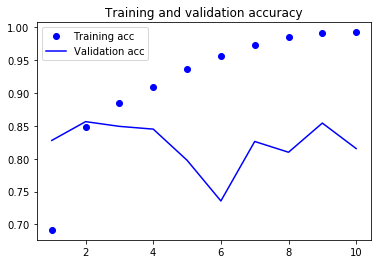

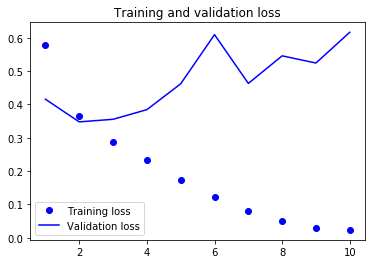

In [7]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## 问题的部分原因在于，输入只考虑了前 500 个单词，而不是整个序列，因此，RNN 获得的信息比前面的基准模型更少。另一部分原因在于，SimpleRNN 不擅长处理长序列，比如文本。